In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import wandb

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from tqdm.notebook import tqdm

from sklearn.datasets import fetch_openml

/home/ivan/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [62]:
class MLP(nn.Module):
    def __init__(self, layers_sizes: list):
        super(MLP, self).__init__()
        self.net = []
        for i, sz in enumerate(layers_sizes):
            if i + 1 != len(layers_sizes):
                self.net.append(nn.Linear(sz, layers_sizes[i + 1]))

    def forward(self, x):
        for layer in self.net:
            x = layer(x)
            x = torch.tanh(x)
        return x

    def parameters(self, recurse: bool = True):
        for layer in self.net:
            for param in layer.parameters():
                yield param

class AE(nn.Module):
    def __init__(self, shape, hidden):
        super(AE, self).__init__()
        self.hidden = hidden

        self.encoder = MLP([shape, hidden, hidden])

        self.decoder = MLP([hidden, hidden, shape])

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def generate(self):
        representation = torch.normal(0.5, 0.3, size=(self.hidden,))
        return self.decoder(representation)

    def generate_onehot(self):
        representation = torch.zeros(self.hidden)
        representation[torch.randint(0, self.hidden, size=(1,))[0]] = 1
        return self.decoder(representation)

    def parameters(self, recurse: bool = True):
        for param in self.encoder.parameters():
            yield param
        for param in self.decoder.parameters():
            yield param


class VAE(nn.Module):

    def __init__(self, encoder_sizes: list, decoder_sizes, dim: int):
        super(VAE, self).__init__()
        self.encoder = MLP(encoder_sizes)

        self.to_mean = nn.Linear(encoder_sizes[-1], dim)
        self.to_cov = nn.Linear(encoder_sizes[-1], dim)
        self.to_decoder = nn.Linear(dim, decoder_sizes[1])

        self.decoder = MLP(decoder_sizes)

    def forward(self, x):
        self.encoder(x)


In [19]:
def learn(nt, X, y, epochs=1):
    optimizer = optim.SGD(nt.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.MSELoss()

    X = Tensor(X)
    y = Tensor(y)

    errors = []
    for epoch in range(epochs):
        for i, x in enumerate(X):
            optimizer.zero_grad()

            outputs = nt(x)
            loss = criterion(outputs, y[i])
            loss.backward()
            optimizer.step()

            errors.append(loss.item())
    return errors

In [20]:
df = fetch_openml('mnist_784')

In [5]:
data = df['data'].to_numpy() > 0
targets = df['target'].to_numpy()

print(data.shape, targets.shape)

(70000, 784) (70000,)


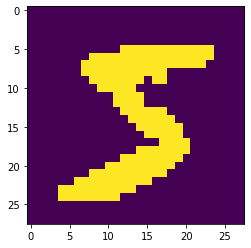

In [6]:
def show(v_img: np.ndarray):
    plt.imshow(v_img.reshape(-1, 28))

show(data[0])

In [63]:
def train_ae(ae, data, n_epochs=1):
    optimizer = optim.SGD(ae.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.MSELoss()

    bar = tqdm(total=data.shape[0]*n_epochs)
    wandb.init(project='VAE', entity='irodkin')

    data_ = torch.from_numpy(data).float()
    for i in range(n_epochs):
        for img in data_:
            optimizer.zero_grad()

            output = ae(img)

            loss = criterion(output, img)
            wandb.log({'loss': loss.item()})

            loss.backward()
            optimizer.step()

            bar.update()
    wandb.finish()

In [75]:
ae = AE(data[0].size, 32)
# ae = nn.Sequential(
#     nn.Linear(data[0].size, 16),
#     nn.Tanh(),
#     nn.Linear(16, data[0].size),
#     nn.Tanh()
# )
train_ae(ae, data[:10000], n_epochs=4)

  0%|          | 0/40000 [00:00<?, ?it/s]

loss,▇▅▄▅▆██▆▃▅▄▅▄▃▃▄▃▃▂▂▃▂▃▁▂▂▂▃▂▆▄▂▁▄▁▃▃▆▃▂
loss,0.08066


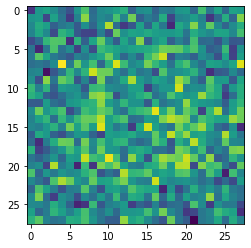

In [81]:
show(ae.generate().detach().numpy())

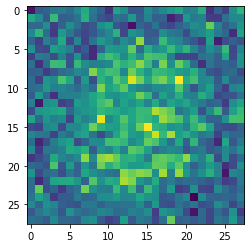

In [82]:
show(ae.generate_onehot().detach().numpy())

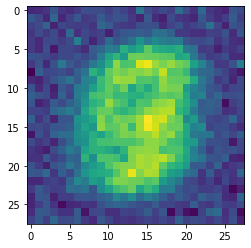

In [80]:
i = 2
# show(data[i])
show(ae(torch.from_numpy(data[i]).float()).detach().numpy())